In [1]:
import sys
sys.path.append('/home/dnelson/project/msprime')
import msprime
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from collections import defaultdict
        
    
# def compute_ind_kinship(self, ind1, ind2):
#     if len(list(self.G.predecessors(ind1))) == 0:
#         if ind1 == ind2:
#             # Founder kinship with self
#             return 0.5
#         if len(list(self.G.predecessors(ind2))) == 0:
#             # Founder kinship with other founder
#             return 0

#     if ind1 == ind2:
#         parents = self.G.predecessors(ind1)
#         return 0.5 * (1 + self.compute_ind_kinship(*parents))
#     else:
#         parents = self.G.predecessors(ind1)
#         return 0.5 * sum(
#             [self.compute_ind_kinship(ind2, p) for p in parents])

# def compute_kinship_recursive(self, samples):
#     n = len(samples)
#     kinship = np.zeros((n, n))
#     sample_idx_dict = dict(zip(samples, range(n)))

#     for s1, s2 in itertools.combinations_with_replacement(samples, 2):
#         sample_idx1 = sample_idx_dict[s1]
#         sample_idx2 = sample_idx_dict[s2]
#         sorted_idx = sorted([sample_idx1, sample_idx2])
#         sorted_idx = tuple(sorted_idx)
#         kinship[sorted_idx] = self.compute_ind_kinship(s1, s2)

#     return kinship

def digraph_kinship(G, samples, kinship, max_time=-1):
    ancestors = defaultdict(dict)
    climbers = {s: set([s]) for s in samples}
    
    i = 0
    while len(climbers) > 0:
        # Adding one only works if branch lengths are also == 1
        # TODO: Make more flexible ^^
        i += 1
        next_climbers = defaultdict(set)
        for sample, climbers in climbers.items():
            for climber in climbers:
                for anc in G.predecessors(climber):
                    next_climbers[sample].add(anc)
                    ancestors[anc][sample] = i

                    # Add kinship with other descendants who
                    # have reached this ancestor
                    for descendant in ancestors[anc]:
                        # print("Adding kinship between", sample, "and", descendant)
                        j = ancestors[anc][descendant]
                        idx = tuple(sorted([sample, descendant]))
                        kinship[idx] += 1 / (2 ** (i + j))
                    
        climbers = next_climbers
                    
    return kinship 


def tree_to_dict_of_dicts(tree):
    dod = {}
    for parent in tree.nodes():
        dod[parent] = {}
        for child in tree.children(parent):
            dod[parent][child] = {
                'branch_length': tree.branch_length(child)
            }
            
    return dod


class PedKinship:
    def __init__(self, G):
        self.G = G
        self.samples = None
        self.ancestor_dists = None
        self.kinship = None
        
    @staticmethod
    def from_array(pedarray):
        G = PedKinship.ped_to_digraph(pedarray)
        
        return PedKinship(G)   
        
    @staticmethod
    def from_txt(pedfile):
        pedarray = np.genfromtxt(
            os.path.expanduser(pedfile),
            skip_header=True,
            dtype=int)
                
        return PedKinship.from_array(pedarray)
        
    @staticmethod
    def ped_to_digraph(pedarray):
        G = nx.DiGraph()

        for child, father, mother in pedarray[:, :3]:
            if father > 0:
                G.add_edge(father, child)
            if mother > 0:
                G.add_edge(mother, child)

        return G
    
    def get_probands(self):
        return [v for v, d in self.G.out_degree() if d == 0]
    
    def _set_samples(self, samples):
        self.samples = samples
        n = len(samples)
        self.kinship = np.zeros((n, n))
    
    def _build_ancestor_dists(self, max_depth=7):
        """
        Builds a dict of dicts. Outer dict links ancestors to probands,
        inner dict holds list of path lengths between the two.
        """
        if self.samples is None:
            raise ValueError("Samples not set")
            
        # Each ancestor has a dict holding a list of path lengths
        # keyed by child ID
        self.ancestor_dists = defaultdict(lambda: defaultdict(list))
        climbers = {x: set([s]) for x, s in enumerate(self.samples)}
        
        i = 0
        while len(climbers) > 0:
            if i > max_depth:
                break

            next_climbers = defaultdict(set)
            for sample_ix, climbers in climbers.items():
                for climber in climbers:
                    self.ancestor_dists[climber][sample_ix].append(i)
                    for anc in self.G.predecessors(climber):
                        next_climbers[sample_ix].add(anc)

            climbers = next_climbers
            # Adding one only works if branch lengths are also == 1
            # TODO: Make more flexible ^^
            i += 1

    def compute_kinship(self, samples, max_depth=7):
        self._set_samples(samples)
        self._build_ancestor_dists(max_depth=max_depth)

        for anc, dists in tqdm(self.ancestor_dists.items(),
                               total=len(self.ancestor_dists),
                               smoothing=0.1):
            children = list(self.G.successors(anc))
            children_dists = [self.ancestor_dists[c] for c in children
                              if c in self.ancestor_dists]

            for paths1, paths2 in itertools.combinations(children_dists, 2):
                for sample_idx1, lengths1 in paths1.items():
                    for sample_idx2, lengths2 in paths2.items():
                        for l1, l2 in itertools.product(lengths1, lengths2):
                            # Since we're looking at the path lengths to 
                            # children of the common ancestor, we add one
                            # to each length
                            kinship = 1 / (2 ** (1 + l1 + 1 + l2 + 1))

                            # Make sure we're only filling upper-triangular
                            # portion of matrix
                            sorted_idx = sorted([sample_idx1, sample_idx2])
                            sorted_idx = tuple(sorted_idx)

                            self.kinship[sorted_idx] += kinship

        return self.kinship


    @staticmethod
    def test_kinship(G=None, pedfile=None):
        if ((G is None and pedfile is None) or 
            (G is not None and pedfile is not None)):
            raise ValueError("Must provide either Graph or pedigree text file")
        
        if G is not None:
            PK = PedKinship(G)
        else:
            PK = PedKinship.from_txt(pedfile)
            
        probands = PK.get_probands()
        kinship = PK.compute_kinship(probands[:10])
        
        return kinship
    

class TSKinship:
    # TODO: Pull out individuals based on ID stored in
    #       metadata
    
    @staticmethod
    def get_sample_inds(ts):
        # NOTE: This only checks if the first associated
        #       node is a sample, which I think is enough
        sample_inds = []
        sample_nodes = set(ts.samples())
        for ind in ts.individuals():
            if len(ind.nodes) > 0:
                if ind.nodes[0] in sample_nodes:
                    sample_inds.append(ind)
                    
        return sample_inds
    
    @staticmethod
    def build_sample_ind_idx_dict(ts, individuals):
        ind_node_dict = {}
        for i, ind in enumerate(individuals):
            if ind.id in set(ts.samples()):
                ind_node_dict.update({n: i for n in ind.nodes})
                
        return ind_node_dict
        
    @staticmethod
    def compute_node_kinship(ts, sample_nodes, max_depth=5):
        n = len(sample_nodes)

        kinship = np.zeros((n, n))
        sample_idx_dict = dict(zip(sample_nodes, range(n)))
        
        for tree in ts.trees():
            L = tree.get_length()
            for s1, s2 in itertools.combinations(sample_nodes, 2):
                if tree.tmrca(s1, s2) > max_depth:
                    continue
                    
                # Make sure we're only filling upper-triangular
                # portion of matrix
                s1_idx = sample_idx_dict[s1]
                s2_idx = sample_idx_dict[s2]
                sorted_idx = sorted([s1_idx, s2_idx])
                sorted_idx = tuple(sorted_idx)
                
                kinship[sorted_idx] += L / ts.get_sequence_length()
                
        return kinship
    
    @staticmethod
    def compute_ind_kinship(ts, individuals, max_depth=5):
        n = len(individuals)
        kinship = np.zeros((n, n))
        min_tmrca = 1000
        closest_pair = None
        
        sample_ind_idx_dict = TSKinship.build_sample_ind_idx_dict(ts, individuals)
        sample_nodes = sample_ind_idx_dict.keys()
        for k, v in sample_ind_idx_dict.items():
            print(k, v)
        
        for tree in tqdm(ts.trees(), total=ts.num_trees):
            L = tree.get_length()
            for s1, s2 in itertools.combinations(sample_nodes, 2):

                if tree.tmrca(s1, s2) > max_depth:
                    continue
                    
#                 if np.abs(s2 - s1) > 1:
#                     print(s1, s2)
#                     print(tree.tmrca(s1, s2))
#                     assert(1 == 2)
                # Make sure we're only filling upper-triangular
                # portion of matrix
                s1_idx = sample_ind_idx_dict[s1]
                s2_idx = sample_ind_idx_dict[s2]
                sorted_idx = sorted([s1_idx, s2_idx])
                sorted_idx = tuple(sorted_idx)
                
                if min_tmrca > tree.tmrca(s1, s2):
                    min_tmrca = tree.tmrca(s1, s2)
                    closest_pair = (s1_idx, s2_idx)
                    
                kinship[sorted_idx] += L / (4 * ts.get_sequence_length())
#                 kinship[sorted_idx] += 1 / 2 ** (2 * tree.tmrca(s1, s2))
    
        print(min_tmrca, closest_pair)
                
        return kinship

In [2]:
# pedfile = '/home/dnelson/project/pedigree_msp/data/small_test_ped.txt'
# pedfile = '/home/dnelson/project/pedigree_msp/data/pedEx.txt'
pedfile = '/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt'

pedigree = msprime.Pedigree.read_txt(pedfile)                                                            

popsize = 1
num_samples = 5
mu = 1e-8
length = 10e8
rho = 1e-8
end_time = None
model = 'dtwf'

pedigree.set_samples(sample_IDs=[418677, 418682, 382315, 8701951, 574617])                           
# pedigree.set_samples(num_samples=num_samples)                           
                                                                            
## Build demographic events for model changes after pedigree sims           
des = []                                                                    
if model is not None:                                                  
    pedigree_end_time = max(pedigree.time)                                  
    des.append(msprime.SimulationModelChange(pedigree_end_time, model))
                                                                            
## For testing, sometimes need to specify num_loci directly                 
rm = msprime.RecombinationMap(                                              
        [0, int(length)],                                              
        [rho, 0], discrete=True)                                       
                                                                            
ts = msprime.simulate(                                              
        num_samples, Ne=popsize, pedigree=pedigree,                    
        model='wf_ped', mutation_rate=mu,                              
        recombination_map=rm,                                               
        end_time=end_time,                                             
        demographic_events=des)             

In [3]:
print(msprime.__file__)

/home/dnelson/project/msprime/msprime/__init__.py


In [4]:
# ts.dump('/home/dnelson/project/pedigree_msp/results/genizon_mismatch_inds.h5')

In [5]:
# ts_inds = msprime.load('/home/dnelson/project/pedigree_msp/results/trees/small_BALSAC_1000inds.h5')
# ts_inds = msprime.load('/home/dnelson/project/pedigree_msp/results/test/trees/small_test_ped.h5')
sample_inds = TSKinship.get_sample_inds(ts)
# sample_inds = sample_inds[:20]
# sample_inds = [sample_inds[x] for x in [100, 101]]
# sample_inds = [sample_inds[x] for x in [12, 19, 100, 41, 478, 101]]
print(sample_inds)
print([int(ind.metadata.decode('utf8')) for ind in sample_inds])

kinship = TSKinship.compute_ind_kinship(ts, sample_inds, max_depth=7)
print(kinship.max())
if kinship.shape[0] < 10:
    print(kinship)

100%|██████████| 629/629 [00:00<00:00, 14651.88it/s]

[{'id': 0, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'382315', 'nodes': array([0, 1], dtype=int32)}, {'id': 1, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'418677', 'nodes': array([2, 3], dtype=int32)}, {'id': 2, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'418682', 'nodes': array([4, 5], dtype=int32)}, {'id': 3, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'574617', 'nodes': array([6, 7], dtype=int32)}, {'id': 4, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'8701951', 'nodes': array([8, 9], dtype=int32)}]
[382315, 418677, 418682, 574617, 8701951]
0 0
1 0
2 1
3 1
4 2
5 2
6 3
7 3
8 4
9 4
4.0 (2, 3)
0.27600541100000003
[[0.         0.0016902  0.016705   0.01145903 0.00150548]
 [0.         0.         0.01878822 0.018868   0.00604911]
 [0.         0.         0.         0.27600541 0.02433178]
 [0.         0.         0.         0.         0.03191785]
 [0.         0.         0.         0.         0.

In [130]:
np.argsort(kinship.ravel())

array([ 0, 22, 21, 20, 18, 17, 16, 15, 23, 11, 12,  6,  5,  4, 10, 24,  1,
        8,  7,  9,  3, 19,  2, 14, 13])

In [131]:
np.argsort(ped_kinship.ravel())

array([22, 21, 20, 17,  5, 16, 15, 23, 11, 10, 24, 12,  6, 18, 19,  4,  0,
        3,  8, 13, 14,  9,  2,  1,  7])

In [146]:
kinship.ravel()

array([0.   , 0.001, 0.014, 0.001, 0.   , 0.   , 0.   , 0.018, 0.016,
       0.005, 0.   , 0.   , 0.   , 0.247, 0.027, 0.   , 0.   , 0.   ,
       0.   , 0.024, 0.   , 0.   , 0.   , 0.   , 0.   ])

In [147]:
ped_kinship.ravel()

array([0.009, 0.042, 0.042, 0.011, 0.005, 0.   , 0.001, 0.251, 0.016,
       0.031, 0.   , 0.   , 0.001, 0.016, 0.031, 0.   , 0.   , 0.   ,
       0.002, 0.003, 0.   , 0.   , 0.   , 0.   , 0.   ])

In [157]:
t = ts.first()

In [158]:
print(t.draw(format='ascii'))

       50          
   +----+---+      
  48       49      
+-+++-+ +-+-++---+ 
| | | | | | 11  12 
| | | | | | +++ +++
0 2 3 8 1 9 5 7 4 6



In [100]:
t.tmrca(1, 2)

18.0

In [159]:
[(ind.id, ind.metadata, ind.nodes) for ind in ts.individuals() if len(ind.nodes) > 0][:20]

[(0, b'382315', array([0, 1], dtype=int32)),
 (1, b'418677', array([2, 3], dtype=int32)),
 (2, b'418682', array([4, 5], dtype=int32)),
 (3, b'574617', array([6, 7], dtype=int32)),
 (4, b'8701951', array([8, 9], dtype=int32)),
 (25, b'2614363', array([10], dtype=int32)),
 (26, b'2614364', array([11], dtype=int32)),
 (73, b'59471', array([12], dtype=int32)),
 (74, b'109661', array([13], dtype=int32)),
 (158, b'2720455', array([14], dtype=int32)),
 (159, b'2761185', array([15], dtype=int32)),
 (160, b'115548', array([16], dtype=int32)),
 (161, b'109265', array([17], dtype=int32)),
 (254, b'2972107', array([18], dtype=int32)),
 (317, b'758774', array([19], dtype=int32)),
 (320, b'761442', array([20], dtype=int32)),
 (427, b'769160', array([21], dtype=int32)),
 (631, b'3964877', array([24], dtype=int32)),
 (865, b'4043507', array([35, 36], dtype=int32)),
 (923, b'3948969', array([23], dtype=int32))]

In [160]:
list(ts.nodes())

[{'id': 0, 'time': 0.0, 'population': 0, 'individual': 0, 'metadata': b'', 'flags': 1},
 {'id': 1, 'time': 0.0, 'population': 0, 'individual': 0, 'metadata': b'', 'flags': 1},
 {'id': 2, 'time': 0.0, 'population': 0, 'individual': 1, 'metadata': b'', 'flags': 1},
 {'id': 3, 'time': 0.0, 'population': 0, 'individual': 1, 'metadata': b'', 'flags': 1},
 {'id': 4, 'time': 0.0, 'population': 0, 'individual': 2, 'metadata': b'', 'flags': 1},
 {'id': 5, 'time': 0.0, 'population': 0, 'individual': 2, 'metadata': b'', 'flags': 1},
 {'id': 6, 'time': 0.0, 'population': 0, 'individual': 3, 'metadata': b'', 'flags': 1},
 {'id': 7, 'time': 0.0, 'population': 0, 'individual': 3, 'metadata': b'', 'flags': 1},
 {'id': 8, 'time': 0.0, 'population': 0, 'individual': 4, 'metadata': b'', 'flags': 1},
 {'id': 9, 'time': 0.0, 'population': 0, 'individual': 4, 'metadata': b'', 'flags': 1},
 {'id': 10, 'time': 4.0, 'population': 0, 'individual': 25, 'metadata': b'', 'flags': 0},
 {'id': 11, 'time': 4.0, 'popu

In [36]:
sample_inds

[{'id': 12, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'214943', 'nodes': array([24, 25], dtype=int32)},
 {'id': 19, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'226757', 'nodes': array([38, 39], dtype=int32)},
 {'id': 100, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'418677', 'nodes': array([200, 201], dtype=int32)},
 {'id': 41, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'296053', 'nodes': array([82, 83], dtype=int32)},
 {'id': 478, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'8682142', 'nodes': array([956, 957], dtype=int32)},
 {'id': 101, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'418682', 'nodes': array([202, 203], dtype=int32)}]

In [114]:
PK = PedKinship.from_txt(pedfile)
probands = PK.get_probands()
sample_ind_IDs = [int(ind.metadata.decode('utf8')) for ind in sample_inds]

ped_kinship = PK.compute_kinship(sample_ind_IDs)
ped_kinship.max()


100%|██████████| 620/620 [00:00<00:00, 137039.87it/s]


0.251007080078125

In [120]:
np.set_printoptions(precision=3, suppress=True)
ped_kinship

array([[0.009, 0.042, 0.042, 0.011, 0.005],
       [0.   , 0.001, 0.251, 0.016, 0.031],
       [0.   , 0.   , 0.001, 0.016, 0.031],
       [0.   , 0.   , 0.   , 0.002, 0.003],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])

In [156]:
ts.first().get_tmrca(4, 5)

18.0

/home/dnelson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


(0, 0.0006378173828125)

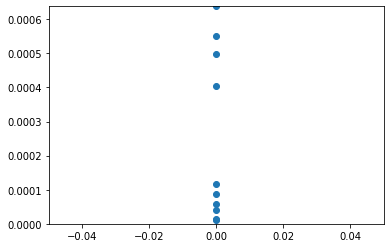

In [27]:
mean_realized = np.mean(kinship, axis=1)
mean_pedigree = np.mean(ped_kinship, axis=1)
plt.scatter(mean_realized, mean_pedigree)
plt.xlim(0, mean_realized.max())
plt.ylim(0, mean_pedigree.max())

In [10]:
ped_kinship[:10, :10]

array([[0.00218201, 0.        , 0.        , 0.        ],
       [0.        , 0.00039673, 0.00018311, 0.00024414],
       [0.        , 0.        , 0.00054932, 0.        ],
       [0.        , 0.        , 0.        , 0.00132751]])

In [14]:
ts = msprime.simulate(10, mutation_rate=1e-8, length=1e8, recombination_rate=1e-8, Ne=10, model='dtwf')

print(ts.first().draw(format='ascii'))

         52        
    +-----+-----+  
    |          32  
    |         +-++ 
   30         |  | 
 +--+---+     |  | 
 |     28     |  | 
 |  +--++--+  |  | 
 |  |  |  20  |  | 
 |  |  |  +++ |  | 
16  |  |  | | |  | 
+++ |  |  | | |  | 
| | | 10  | | | 12 
| | | +++ | | | +++
0 8 6 1 3 5 9 2 4 7



In [72]:
TSKinship.compute_kinship(ts, ts.samples())

AttributeError: type object 'TSKinship' has no attribute 'compute_kinship'

In [10]:
list(ts.samples())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [224]:
t = ts.first()

In [225]:
t.get_length()

1502009.2856274692

In [226]:
ts.get_sequence_length()

10000000.0

In [192]:
PedKinship.test_kinship(pedfile=pedfile)

100%|██████████| 1581/1581 [00:00<00:00, 98955.33it/s]


array([[0.00639343, 0.01106262, 0.00831604, 0.00363159, 0.00608826,
        0.00590515, 0.00672913, 0.00411987, 0.00653076, 0.00184631],
       [0.        , 0.00265503, 0.00498962, 0.00514221, 0.00437927,
        0.00317383, 0.00283813, 0.00312805, 0.00372314, 0.00323486],
       [0.        , 0.        , 0.00234985, 0.00688171, 0.01139832,
        0.01063538, 0.01271057, 0.0038147 , 0.01091003, 0.00244141],
       [0.        , 0.        , 0.        , 0.0057373 , 0.0078125 ,
        0.00466919, 0.01490784, 0.00221252, 0.00488281, 0.00305176],
       [0.        , 0.        , 0.        , 0.        , 0.01733398,
        0.00434875, 0.03022766, 0.00224304, 0.00671387, 0.00186157],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00213623, 0.00215149, 0.01075745, 0.00502014, 0.00106812],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00294495, 0.00213623, 0.00350952, 0.00221252],
       [0.        , 0.        , 0.       

In [74]:
# pedfile = '/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt'
# PK = PedKinship.from_txt(pedfile)
# G = PK.G
# PedKinship.test_kinship(pedfile=pedfile)

In [ ]:
ts.get_s

In [149]:
PK = PedKinship(G)

probands = PK.get_probands()
# PK.set_samples(probands[:5000])
# PK.build_ancestor_dists(max_depth=5)

In [150]:
children = PK.compute_kinship(probands, max_depth=5)

100%|██████████| 145509/145509 [00:03<00:00, 41357.28it/s]


In [140]:
PK.kinship.max()

0.51611328125

In [146]:
np.where((PK.kinship < 0.5) & (PK.kinship > 0.4))[0].shape

(0,)

In [76]:
probands[38]

199325

In [77]:
probands[39]

199329

In [80]:
nx.lowest_common_ancestor(PK.G, 199325, 199329)

91256

In [82]:
list(PK.G.successors(91256))

[199325, 199329]

In [187]:
TK = TSKinship(ts)

In [202]:
TK.compute_kinship(ts.samples())

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [204]:
ts.num_trees

405

In [165]:
t = ts.first()
t.

In [102]:
samples = [7, 6]
kinship = init_sparse_kinship(samples)

for tree in ts.trees():
    g = nx.DiGraph(tree_to_dict_of_dicts(ts.first()))
    a = digraph_kinship(g, samples, kinship)

In [103]:
kinship.data

array([list([]), list([]), list([]), list([]), list([]), list([]),
       list([0.75, 0.125]), list([0.9375])], dtype=object)

In [47]:
a.nonzero()

(array([6, 6, 7], dtype=int32), array([6, 7, 7], dtype=int32))

In [103]:
list(g_ped.predecessors(79826))

[76060, 77127]

In [114]:
leaves = get_digraph_leaves(g_ped)

In [115]:
leaves[:2]

[79826, 99455]

In [119]:

list(nx.all_simple_paths(g_ped, 79826, 99455, cutoff=15))

[]

In [122]:
ts = msprime.load('/home/dnelson/project/pedigree_msp/results/Luke/chrom1_4134samples_Ne10000.h5')
pedfile = '/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt'
ped = np.genfromtxt('/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt',
                    skip_header=True, dtype=int)

In [5]:
g_ped = ped_to_digraph(ped)


np.histogram([d for v, d in g_ped.out_degree()], bins=range(10))

(array([  4134, 146021,  39059,  19652,  11718,   7535,   4499,   2896,
          2612]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [27]:
leaves = [v for v, d in g_ped.out_degree() if d == 0]

In [41]:
%timeit a = nx.ancestors(g_ped, 79826)

2.71 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
nx.draw(g, with_labels=True)

100%|██████████| 50/50 [00:00<00:00, 10667.64it/s]


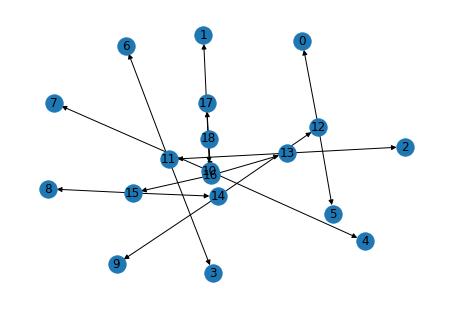

In [69]:
plt.show()

In [27]:
tree = ts.first()

# a dictionary of dictionaries to represent our distance matrix
dist_dod = collections.defaultdict(dict)
for source, target in itertools.combinations(tree.samples(), 2):
    dist_dod[source][target] = nx.shortest_path_length(
        g, source=source, target=target, weight="branch_length"
    )
    dist_dod[target][source] = dist_dod[source][target]

# extract the nearest neighbor of nodes 0, 1, and 2
nearest_neighbor_of = [min(dist_dod[u], key=dist_dod[u].get) for u in range(3)]

print(dict(zip(range(3), nearest_neighbor_of)))

{0: 7, 1: 6, 2: 0}


In [9]:
ts = msprime.simulate(10, mutation_rate=1e-8, length=1e8, Ne=10, model='dtwf')
g = nx.Graph(tree_to_dict_of_dicts(ts.first()))
print(ts.first().draw(format='ascii'))

     18            
  +---+---+        
  |      17        
  |    +--+-+      
  |    |   16      
  |    |  +-+--+   
 15    |  |    |   
+-++   |  |    |   
|  |  14  |    |   
|  |  +++ |    |   
|  |  | | |   13   
|  |  | | |  +-+-+ 
| 12  | | |  |  11 
| +++ | | |  |  +++
| | | | | | 10  | |
| | | | | | +++ | |
8 4 9 5 6 3 0 2 1 7



Taking the graph-based distance, weighted by branch lengths, how do we convert to kinship? $\frac{1}{2 ^{(d / 2)}}$?

In [40]:
for i, path in enumerate(nx.shortest_simple_paths(g_ped_undirected, leaves[0], leaves[1])):
    if len(path) > 12:
        print(i, path)
        break

28 [79826, 76060, 75400, 763677, 760738, 69797, 69790, 153935, 146753, 764950, 146750, 76133, 99455]


In [29]:
g_ped_undirected = nx.Graph(g_ped)

In [42]:
c = nx.communicability(g_ped_undirected)

MemoryError: Unable to allocate array with shape (238902, 238902) and data type float64

In [105]:
nx.lowest_common_ancestor(g_ped, leaves[0], leaves[1])

773180